In [1]:
from statsmodels.datasets import sunspots
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
import numpy as np
import pmdarima as pm
from pmdarima.arima import auto_arima, ARIMA
from pmdarima.arima.stationarity import ADFTest
from pmdarima.utils import check_exog
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
import pickle
from matplotlib import pyplot as plt
from matplotlib import axes
from matplotlib.figure import Figure
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = sunspots.load_pandas().data
df.columns = ['yr', 'y']
df.yr = df.yr.astype(np.int32)
df.y = df.y.astype(np.float32)
df.index = df.yr
df.drop(labels=['yr'], axis=1, inplace=True)
df.describe()

,y
count,309.000000
mean,49.752102
std,40.452595
min,0.000000
25%,16.000000
50%,40.000000
75%,69.800003
max,190.199997


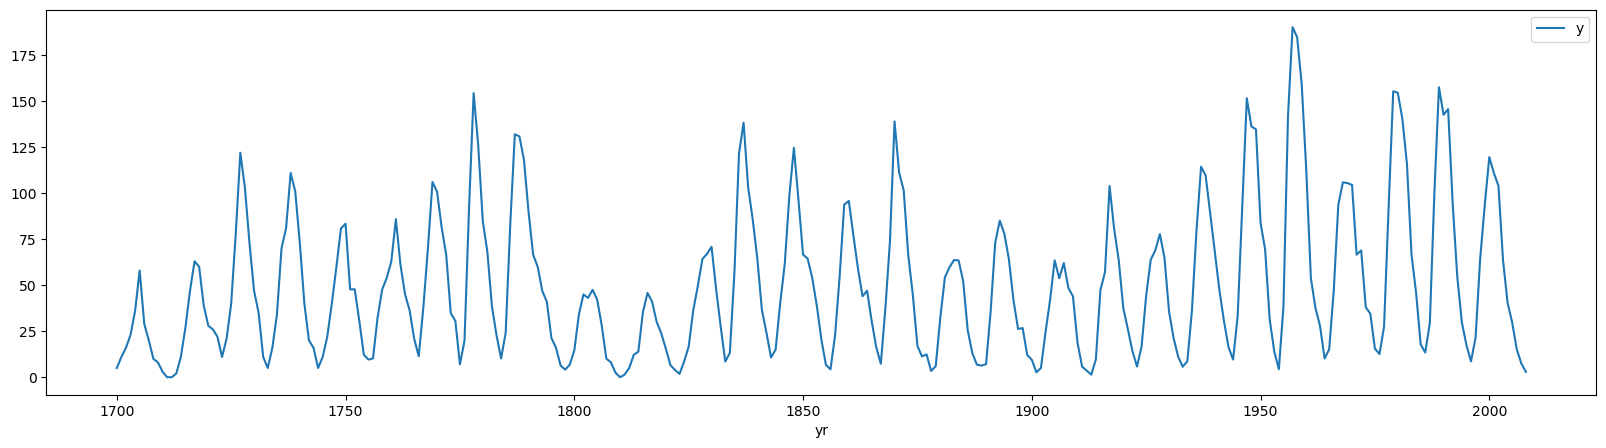

In [3]:
_ = df.plot(figsize=(20,5))
plt.show()

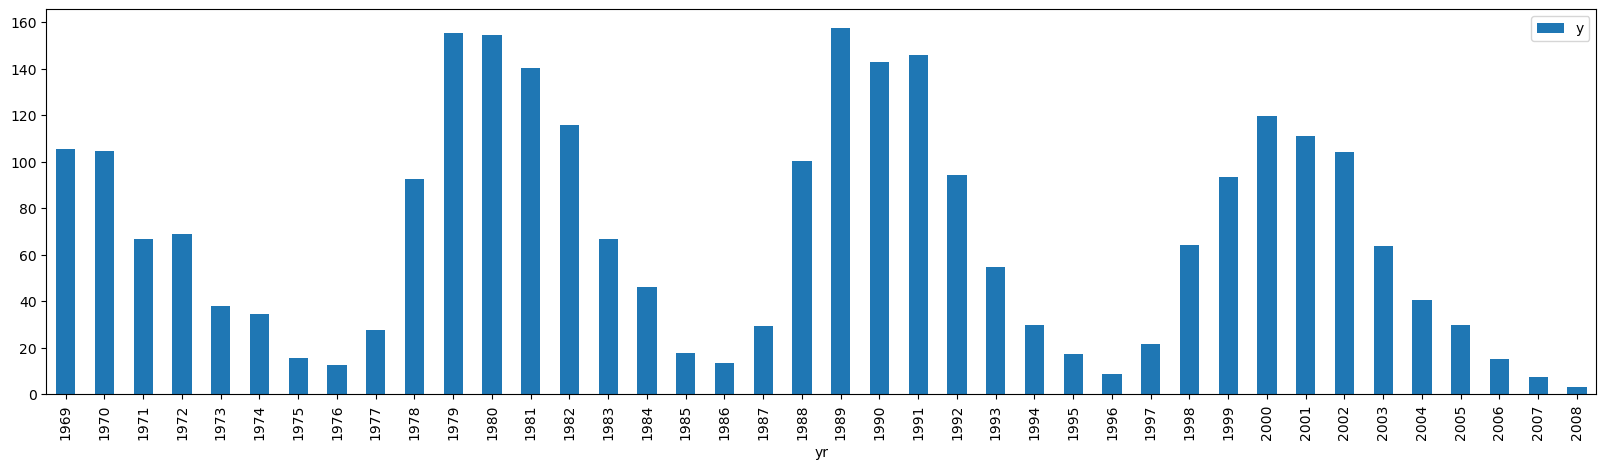

In [4]:
_ = df.tail(40).plot.bar(figsize=(20,5))
plt.show()

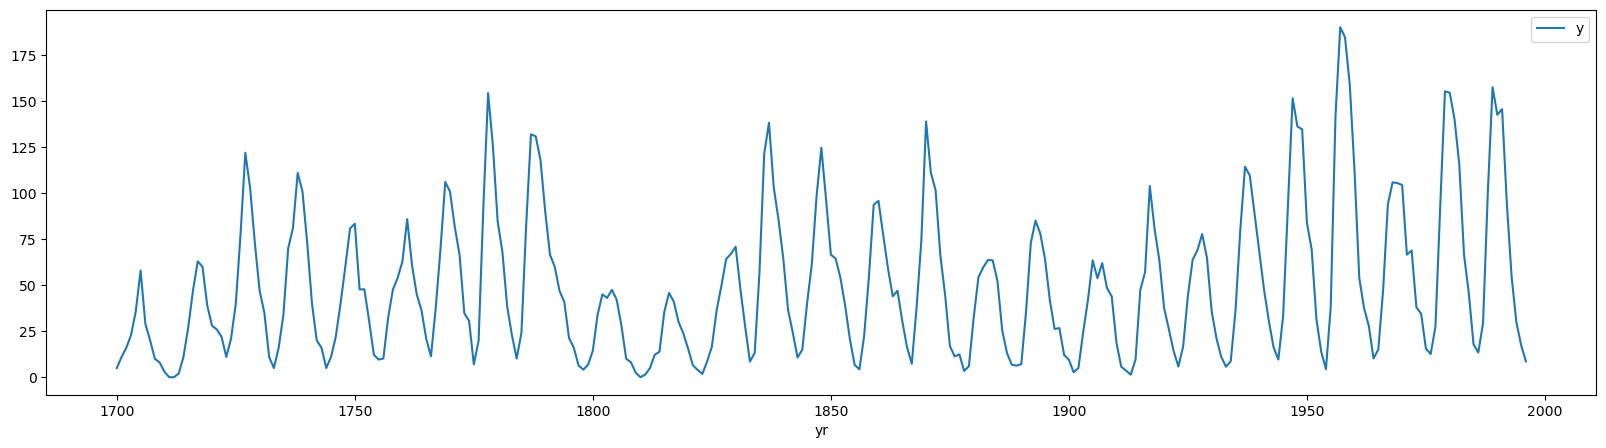

In [5]:
val = df.tail(12)
train = df.drop(val.index)
_ = train.plot(figsize=(20, 5))
plt.show()

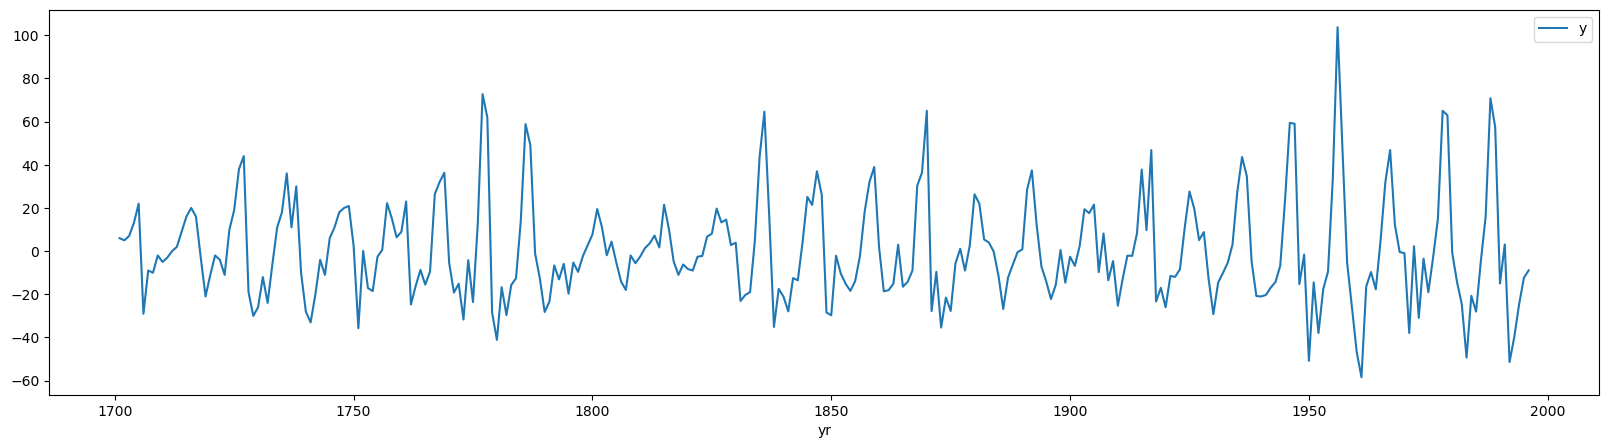

In [6]:
diff = train.diff(1)
_ = diff.plot(figsize=(20,5))
plt.show()

In [ ]:
adf = ADFTest()
adf.should_diff(df.y.values)
# Even though ADF says not to difference, we should!

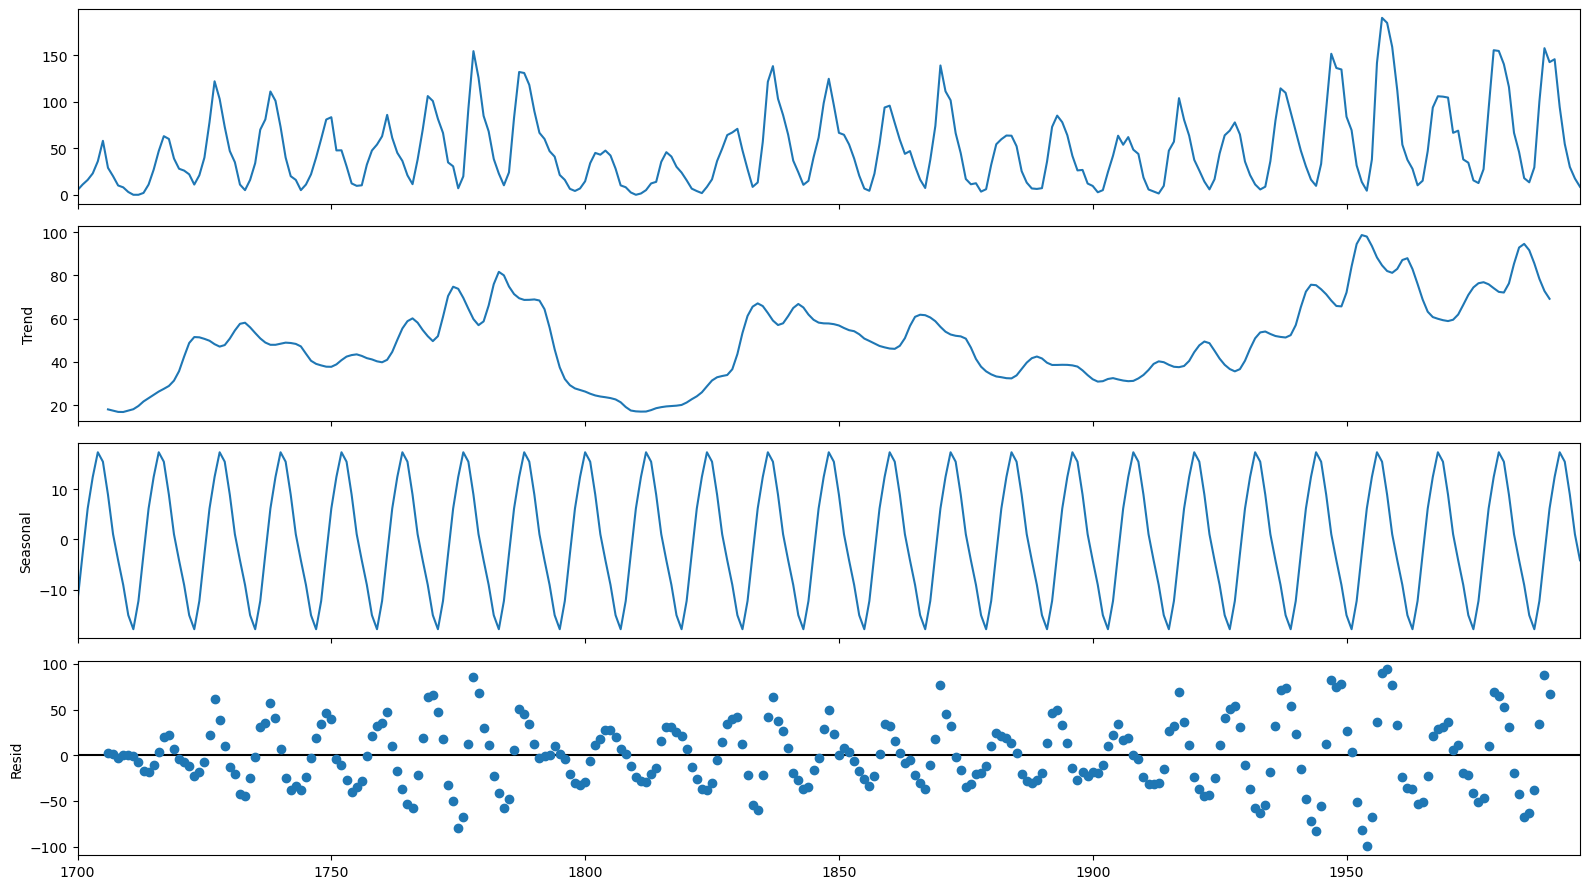

In [8]:
fig: Figure = seasonal_decompose(x=train, period=12).plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

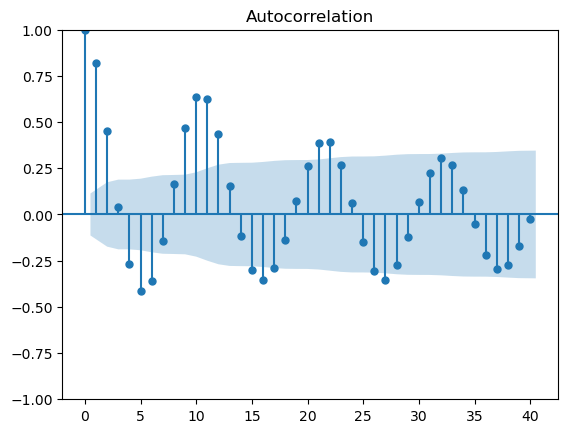

In [28]:
_ = sm.graphics.tsa.plot_acf(train, lags=40)

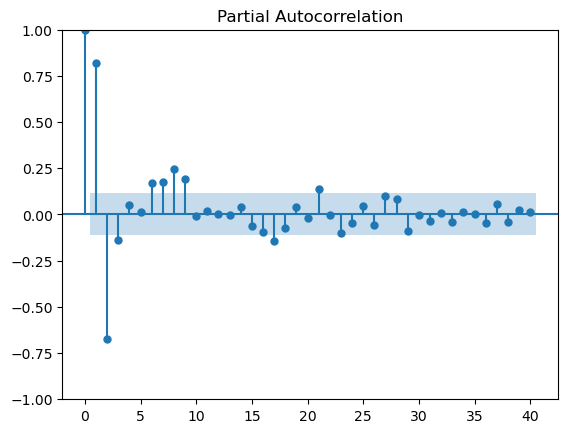

In [10]:
_ = sm.graphics.tsa.plot_pacf(train.values, lags=40)

In [11]:
stepwise_fit = pm.auto_arima(train, start_p=0, start_q=0,
                             max_p=9, max_q=9, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True,
                             information_criterion='bic')

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,1,1)[12]             : BIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=2714.811, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=2634.978, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=inf, Time=0.50 sec
 ARIMA(1,1,0)(0,1,0)[12]             : BIC=2665.776, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : BIC=2629.298, Time=0.27 sec
 ARIMA(1,1,0)(2,1,1)[12]             : BIC=inf, Time=0.85 sec
 ARIMA(1,1,0)(1,1,1)[12]             : BIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(2,1,0)[12]             : BIC=2696.796, Time=0.19 sec
 ARIMA(2,1,0)(2,1,0)[12]             : BIC=2613.562, Time=0.33 sec
 ARIMA(2,1,0)(1,1,0)[12]             : BIC=2622.448, Time=0.16 sec
 ARIMA(2,1,0)(2,1,1)[12]             : BIC=inf, Time=0.85 sec
 ARIMA(2,1,0)(1,1,1)[12]             : BIC=inf, Time=0.41 sec
 ARIMA(3,1,0)(2,1,0)[12]             : BIC=2589.612, Time=0.41 sec
 ARIMA(3,1,0)(1,1,0)[12]             : BIC=2602.4

### Best fit
ARIMA(8,1,0)(2,1,0)[12]

In [12]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  297
Model:             SARIMAX(8, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1228.369
Date:                            Wed, 14 May 2025   AIC                           2478.737
Time:                                    23:38:27   BIC                           2518.876
Sample:                                         0   HQIC                          2494.829
                                            - 297                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1844      0.053      3.503      0.000       0.081       0.288
ar.L2         -0.2482      0.059     -4.232      0.000      -0.363      -0.133
ar.L3         -0.3599      0.069     -5.196      0.000      -0.496      -0.224
ar.L4         -0.2274      0.063     -3.634      0.000      -0.350      -0.105
ar.L5         -0.3077      0.061     -5.076      0.000      -0.427      -0.189
ar.L6         -0.2428      0.057     -4.260      0.000      -0.355      -0.131
ar.L7         -0.2339      0.060     -3.879      0.000      -0.352      -0.116
ar.L8         -0.2597      0.052     -5.037      0.000      -0.361      -0.159
ar.S.L12      -0.6061      0.066     -9.130      0.000      -0.736      -0.476
ar.S.L24      -0.2930      0.057     -5.159      0.000      -0.404      -0.182
sigma2       325.3998     24.965     13.034      0.000     276.469     374.330
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                15.65
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.24
Prob(H) (two-sided):                  0.26   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

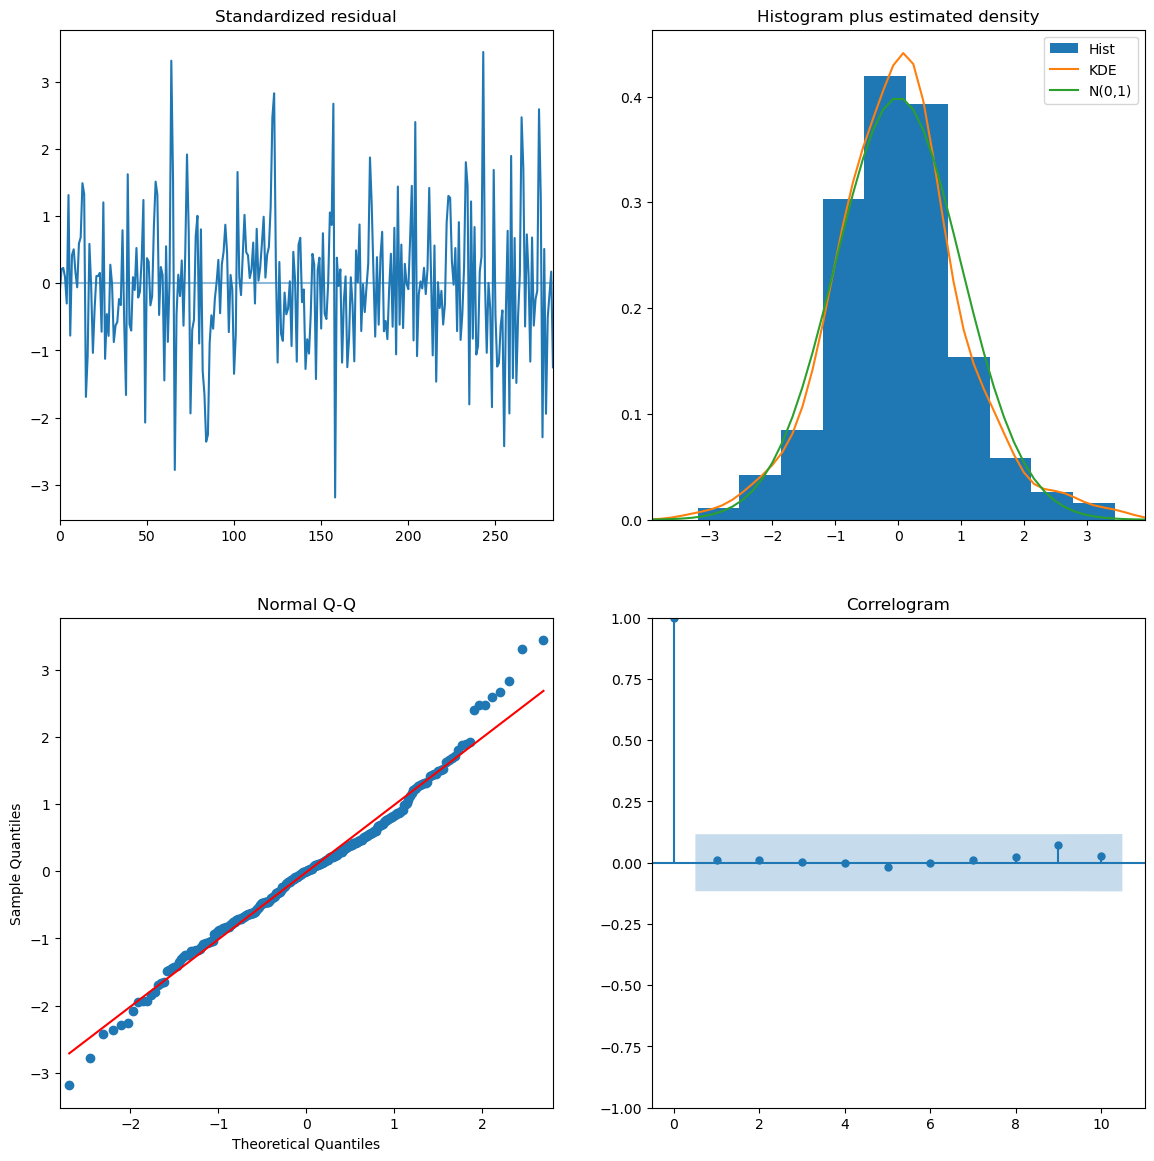

In [13]:
_ = stepwise_fit.plot_diagnostics(figsize=(14, 14))
plt.show()

df_train = pd.DataFrame(columns=['y', 'yhat'])
df_train.y = train.y.values
df_train.yhat = np.float32(stepwise_fit.fittedvalues())
df_train.index = train.index
_ = df_train.plot(figsize=(20, 5))

### Train Forecast

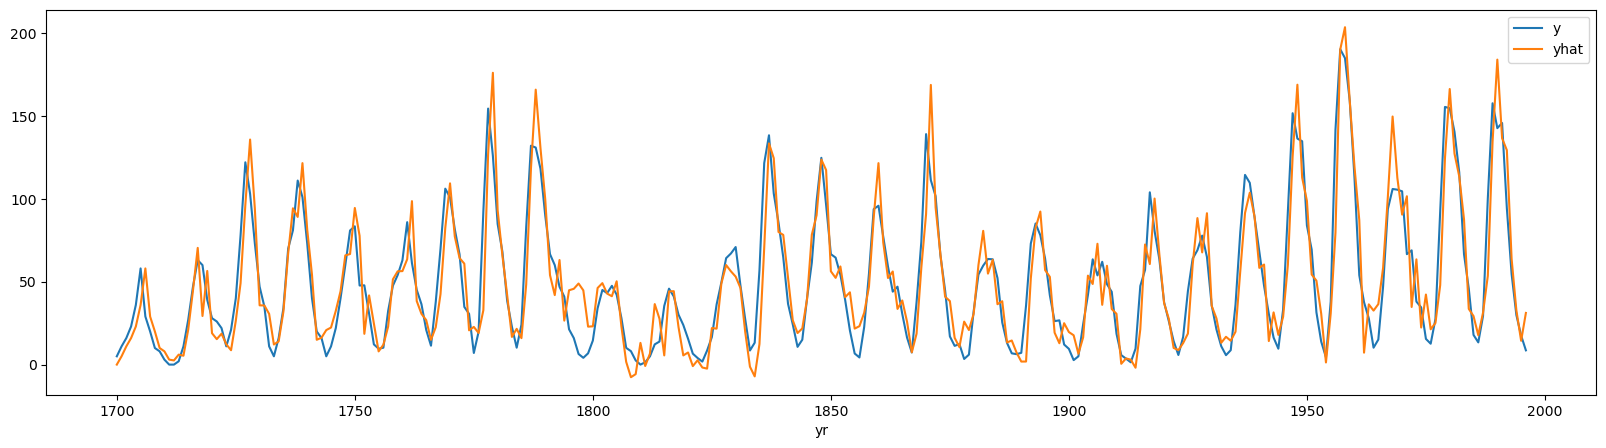

In [20]:
df_train = pd.DataFrame(columns=['y', 'yhat'])
df_train.y = train.y.values
df_train.yhat = stepwise_fit.fittedvalues().values
df_train.index = train.index
_ = df_train.plot(figsize=(20, 5))

### Validation Forecast vs. Actual

### Validation MAPE

In [15]:
forecast = np.float32(stepwise_fit.predict(n_periods=12))
pm.metrics.smape(val.y.values, forecast)

39.437516907094796

### Forecast to 2030

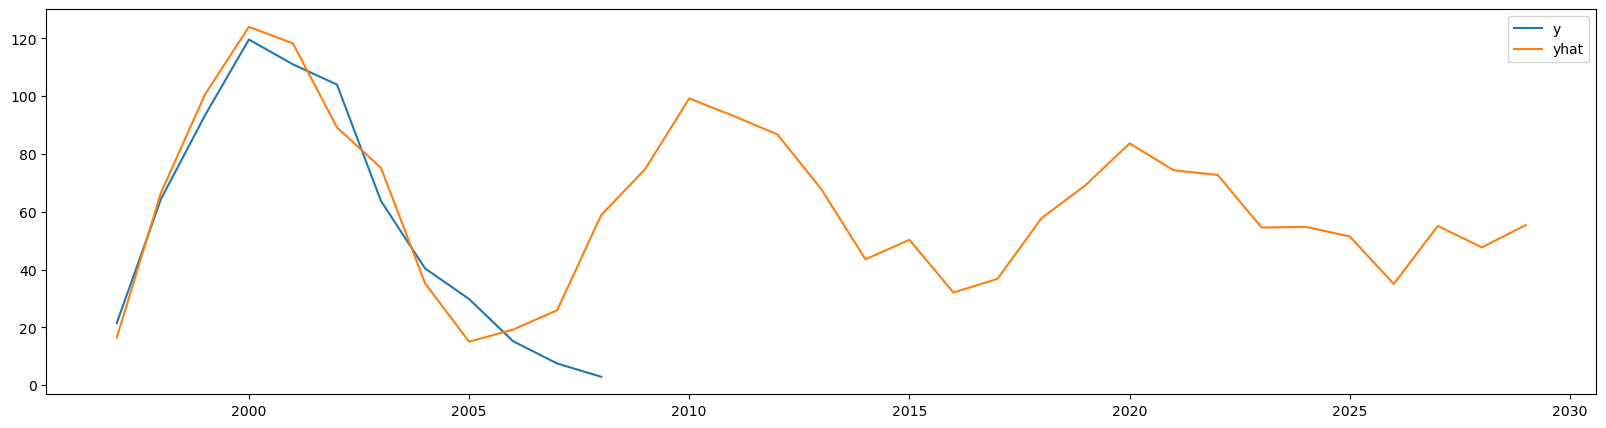

In [23]:
df_val = pd.DataFrame(columns=['y', 'yhat'])
df_val.y = np.concatenate([val.y.values, [None for i in range(0, 21)]])
df_val.yhat = np.float32(stepwise_fit.predict(n_periods=33))
df_val.index = np.concatenate([val.index, [i for i in range(2009, 2030)]])
_ = df_val.plot(figsize=(20,5))